# Evaluating observed vs. modeled GEV parameters

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import font_manager
import pyarrow.parquet as pq
import seaborn as sns
from scipy import stats
from scipy.stats import genextreme as gev
from functools import reduce

Data locations

In [2]:
loc_params = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/Fitted_Parameters/"
loc_emissions = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/Emissions/"
loc_carbonmajors = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/CarbonMajors/"
loc_figs = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Figures/"
loc_txx = "/N/project/climatesociety/datasets/ERA5/annual/"
loc_rx1day = "/N/project/climatesociety/datasets/CPC/annual/"
loc_out = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/GEV_Predictions/"
loc_lsm = "/N/project/climatesociety/datasets/LandSea/2p5degree/"
loc_ceds = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/CEDS/CEDS_v_2024_04_01_aggregate/"
loc_mmlea_rx1day = "/N/project/climatesociety/datasets/MMLEA/annual/rx1day/"
loc_mmlea_txx = "/N/project/climatesociety/datasets/MMLEA/annual/txx/"

Custom cmap for precip

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('BrBG', 256)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 0.5, 128)),
                       bottom(np.linspace(0, 1, 128))))
precip_cmap = ListedColormap(newcolors, name='BrownBlue')

/tmp/ipykernel_2299663/2496032520.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('BrBG', 256)
/tmp/ipykernel_2299663/2496032520.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('Blues', 128)


Land sea mask

In [4]:
lsm_in = xr.open_dataarray(loc_lsm+"IMERG_land1_sea0_mask_2p5degree.nc")
lsm = lsm_in.where(lsm_in==1,np.nan)

GEV parameters fitted on observations

In [5]:
params_df_txx_obs = pq.read_table(loc_params+"era5_txx_gev_cumulativeemissions_params.parquet").to_pandas()
params_df_txx_obs = params_df_txx_obs.set_index(["lat","lon"])
params_txx_obs = params_df_txx_obs.to_xarray()

params_df_rx1day_obs = pq.read_table(loc_params+"cpc_rx1day_gev_cumulativeemissions_params.parquet").to_pandas()
params_df_rx1day_obs = params_df_rx1day_obs.set_index(["lat","lon"])
params_rx1day_obs = params_df_rx1day_obs.to_xarray()

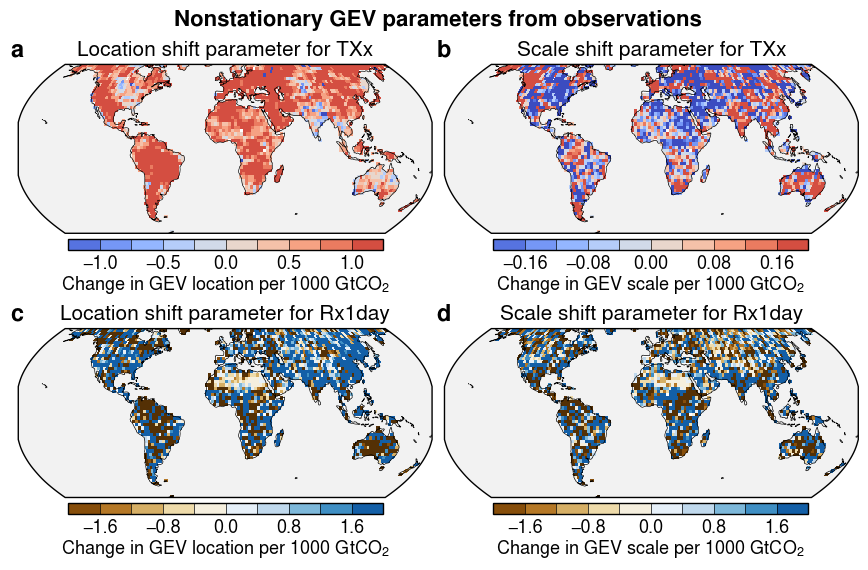

In [6]:
fig = plt.figure(figsize=(10,6))
tfs = 15
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.94,top=0.92,bottom=0.09,wspace=0.03,hspace=0.13)

extremes = ["txx","rx1day"]
ext_names = ["TXx","Rx1day"]
nms = ["Location","Scale"]
lefts = [0.15,0.575]
bottoms = [0.557,0.117]

lbx = -0.02
lby = 1.05

for ee in np.arange(0,len(extremes),1):
    if ee==0:
        ds = params_txx_obs
        lbs = ["a","b"]
    elif ee==1:
        ds = params_rx1day_obs
        lbs = ["c","d"]
        
    for j in np.arange(0,len(nms),1):
        if (j == 0)&(ee==0):
            dat_all = ds.data_vars["mu1"]*1000
            cmin = -1.25
            cmax = 1.25
            nrange = 11
        elif (j == 0)&(ee==1):
            dat_all = ds.data_vars["mu1"]*1000
            cmin = -2
            cmax = 2
            nrange = 11
        elif (j == 1)&(ee==0):
            dat_all = ds.data_vars["sigma1"]*1000
            cmin = -0.2
            cmax = 0.2
            nrange = 11
        elif (j==1)&(ee==1):
            dat_all = ds.data_vars["sigma1"]*1000
            cmin = -2
            cmax = 2
            nrange = 11

        # plot median and uncertainty
        dat = dat_all*1.0 #median(dim="model")
        
        # draw map
        ax = plt.subplot(gs1[ee,j],projection=ccrs.Robinson())
        ax.set_extent([-180,180,-65,65],crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_zorder(11)
        ax.coastlines(linewidth=0.5,zorder=9)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.95,0.95,0.95])
        
        plt.title(nms[j]+" shift parameter for "+ext_names[ee],fontsize=tfs)
        plt.text(lbx,lby,lbs[j],fontsize=17,transform=ax.transAxes,fontweight="bold")
        
        # cmap
        
        bounds = np.linspace(cmin,cmax,nrange)
        if ee==0:
            cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
        else:
            cols = precip_cmap(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
        
        # plot
        data_plot = dat.clip(min=cmin+(cmin*0.01),max=cmax-(cmax*0.01))
        ax.pcolormesh(data_plot.lon,data_plot.lat,data_plot,
                      zorder=7,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)

        # cbar
        cbar_ax = fig.add_axes([lefts[j],bottoms[ee],0.315,0.018])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                              drawedges=True,extend="neither")
        cb.ax.tick_params(direction="in",width=0,which="major",labelsize=tfs-2)
        cb.ax.tick_params(direction="in",width=0,which="minor")
        cb.ax.set_xticklabels
        cb.set_label(r"Change in GEV "+nms[j].lower()+r" per 1000 GtCO$_2$",labelpad=1,fontsize=tfs-2)
        
plt.figtext(0.52,0.93,r"Nonstationary GEV parameters from observations",weight='bold',fontsize=tfs+1,
            ha="center")

plt.savefig(loc_figs+"Obs_Parameter_Maps.pdf")
plt.show()

Read modeled parameters over the observational interval

In [7]:
scen = "ssp585"
params_df_txx = pq.read_table(loc_params+"mmlea_txx_gev_"+scen+"_cumulativeemissions_bymodel_params_1979-2024.parquet").to_pandas().drop(columns="ks_pvalue")
params_df_txx = params_df_txx.set_index(["lat","lon","model"])
params_txx = params_df_txx.to_xarray()
params_df_rx1day = pq.read_table(loc_params+"mmlea_rx1day_gev_"+scen+"_cumulativeemissions_bymodel_params_1979-2024.parquet").to_pandas().drop(columns="ks_pvalue")
params_df_rx1day = params_df_rx1day.set_index(["lat","lon","model"])
params_rx1day = params_df_rx1day.to_xarray()

models = reduce(np.intersect1d,(params_txx.model.values,params_rx1day.model.values))
modelnames = np.array([x.split("_")[0] for x in models])
print(np.unique(modelnames))
print(len(np.unique(modelnames)))
print(len(models))

['ACCESS-ESM1-5' 'CanESM5' 'EC-Earth3' 'IPSL-CM6A-LR' 'MIROC-ES2L'
 'MIROC6' 'MPI-ESM1-2-LR' 'UKESM1-0-LL']
8
171


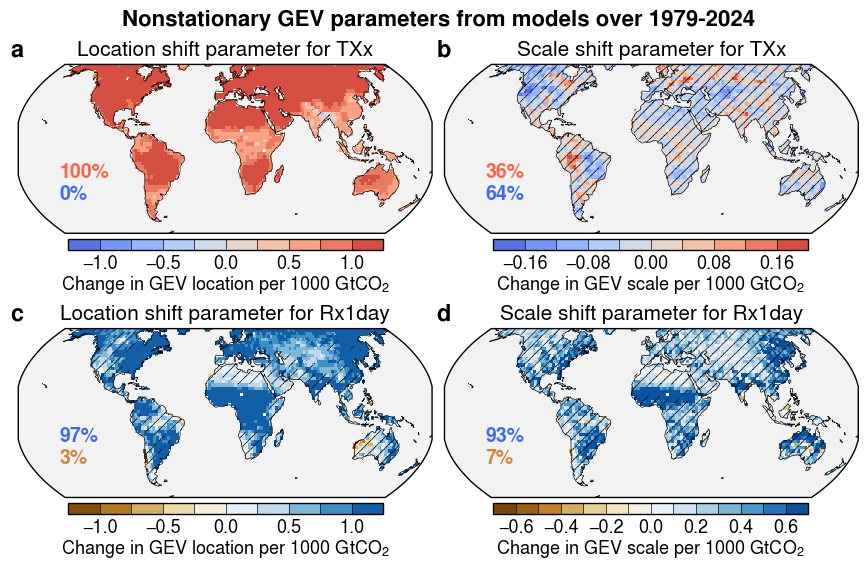

In [8]:
fig = plt.figure(figsize=(10,6))
tfs = 15
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.94,top=0.92,bottom=0.09,wspace=0.03,hspace=0.13)

extremes = ["txx","rx1day"]
ext_names = ["TXx","Rx1day"]
nms = ["Location","Scale"]
lefts = [0.15,0.575]
bottoms = [0.557,0.117]

lbx = -0.02
lby = 1.05

for ee in np.arange(0,len(extremes),1):
    if ee==0:
        ds = params_txx
        lbs = ["a","b"]
    elif ee==1:
        ds = params_rx1day
        lbs = ["c","d"]
        
    for j in np.arange(0,len(nms),1):
        if j == 0:
            dat_all = ds.data_vars["mu1"].loc[:,:,models]*1000
            cmin = -1.25
            cmax = 1.25
            nrange = 11
        elif (j == 1)&(ee==0):
            dat_all = ds.data_vars["sigma1"].loc[:,:,models]*1000
            cmin = -0.2
            cmax = 0.2
            nrange = 11
        elif (j==1)&(ee==1):
            dat_all = ds.data_vars["sigma1"].loc[:,:,models]*1000
            cmin = -0.7
            cmax = 0.7
            nrange = 15

        # plot median and uncertainty
        dat = dat_all.median(dim="model")
        dat_uncert_inc = (dat_all>0).mean(dim="model")
        dat_uncert_dec = (dat_all<0).mean(dim="model")

        # draw map
        ax = plt.subplot(gs1[ee,j],projection=ccrs.Robinson())
        ax.set_extent([-180,180,-65,65],crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_zorder(11)
        ax.coastlines(linewidth=0.5,zorder=9)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.95,0.95,0.95])
        
        plt.title(nms[j]+" shift parameter for "+ext_names[ee],fontsize=tfs)
        plt.text(lbx,lby,lbs[j],fontsize=17,transform=ax.transAxes,fontweight="bold")
        
        # cmap
        
        bounds = np.linspace(cmin,cmax,nrange)
        if ee==0:
            cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
        else:
            cols = precip_cmap(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
        
        # plot
        data_plot = dat.clip(min=cmin+(cmin*0.01),max=cmax-(cmax*0.01))
        ax.pcolormesh(data_plot.lon,data_plot.lat,data_plot,
                      zorder=7,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
        data_plot_u1 = data_plot.where((dat>0)&(dat_uncert_inc<0.66),np.nan)
        data_plot_u2 = data_plot.where((dat<0)&(dat_uncert_dec<0.66),np.nan)
        ax.pcolor(data_plot_u1.lon,data_plot_u1.lat,data_plot_u1,hatch="///",
                      zorder=8,transform=ccrs.PlateCarree(),cmap=ListedColormap(['none']))
        ax.pcolor(data_plot_u2.lon,data_plot_u2.lat,data_plot_u2,hatch="///",
                      zorder=8,transform=ccrs.PlateCarree(),cmap=ListedColormap(['none']))

        # print out stat
        dat_flat = dat.values.flatten()
        dat_notna = dat_flat[~np.isnan(dat_flat)]
        #print(np.mean(dat_notna>0))

        if ee==0:
            textcol1 = "tomato"
            textcol2 = "royalblue"
        else:
            textcol1 = "royalblue"
            textcol2 = "peru"
            
        plt.text(0.1,0.33,str(int(np.around(np.mean(dat_notna>0)*100)))+"%",fontsize=14,
                 color=textcol1,fontweight="bold",transform=ax.transAxes)
        plt.text(0.1,0.2,str(int(np.around(np.mean(dat_notna<0)*100)))+"%",fontsize=14,
                 color=textcol2,fontweight="bold",transform=ax.transAxes)


        # cbar
        cbar_ax = fig.add_axes([lefts[j],bottoms[ee],0.315,0.018])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                              drawedges=True,extend="neither")
        cb.ax.tick_params(direction="in",width=0,which="major",labelsize=tfs-2)
        cb.ax.tick_params(direction="in",width=0,which="minor")
        cb.ax.set_xticklabels
        cb.set_label(r"Change in GEV "+nms[j].lower()+r" per 1000 GtCO$_2$",labelpad=1,fontsize=tfs-2)
        
plt.figtext(0.52,0.93,r"Nonstationary GEV parameters from models over 1979-2024",weight='bold',fontsize=tfs+1,
            ha="center")

plt.show()

Plot maps of where maps and obs are consistent within 95%

In [9]:
plower = 0.005
pupper = 0.995
txx_mu1_model_vs_obs = ((params_txx.data_vars["mu1"].loc[:,:,models] - params_txx_obs.data_vars["mu1"]) > 0).mean(dim="model").load()
txx_mu1_model_vs_obs_plot = xr.where((txx_mu1_model_vs_obs<pupper)&(txx_mu1_model_vs_obs>plower)&(~np.isnan(params_txx.mu1.median(dim="model"))),1.0,np.nan)

txx_sigma1_model_vs_obs = ((params_txx.data_vars["sigma1"].loc[:,:,models] - params_txx_obs.data_vars["sigma1"]) > 0).mean(dim="model").load()
txx_sigma1_model_vs_obs_plot = xr.where((txx_sigma1_model_vs_obs<pupper)&(txx_sigma1_model_vs_obs>plower)&(~np.isnan(params_txx.sigma1.median(dim="model"))),1.0,np.nan)

rx1day_mu1_model_vs_obs = ((params_rx1day.data_vars["mu1"].loc[:,:,models] - params_rx1day_obs.data_vars["mu1"]) > 0).mean(dim="model").load()
rx1day_mu1_model_vs_obs_plot = xr.where((rx1day_mu1_model_vs_obs<pupper)&(rx1day_mu1_model_vs_obs>plower)&(~np.isnan(params_rx1day.mu1.median(dim="model"))),1.0,np.nan)

rx1day_sigma1_model_vs_obs = ((params_rx1day.data_vars["sigma1"].loc[:,:,models] - params_rx1day_obs.data_vars["sigma1"]) > 0).mean(dim="model").load()
rx1day_sigma1_model_vs_obs_plot = xr.where((rx1day_sigma1_model_vs_obs<pupper)&(rx1day_sigma1_model_vs_obs>plower)&(~np.isnan(params_rx1day.sigma1.median(dim="model"))),1.0,np.nan)

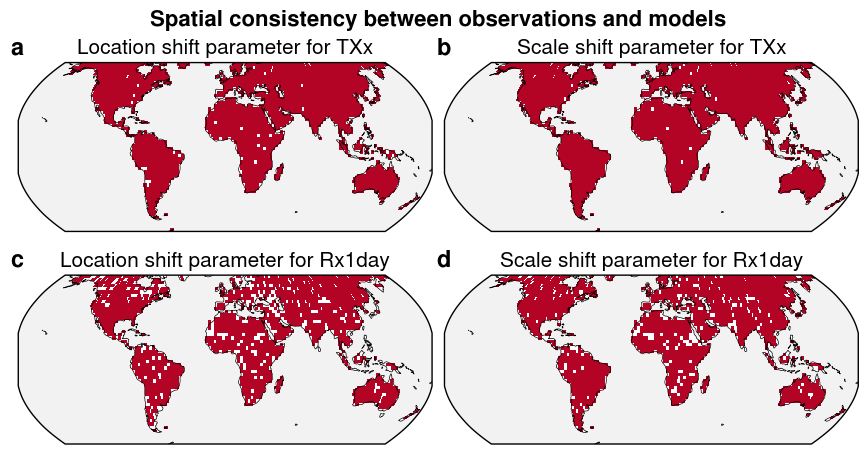

In [10]:
fig = plt.figure(figsize=(10,5))
tfs = 15
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.94,top=0.89,bottom=0.06,wspace=0.03,hspace=0.05)

extremes = ["txx","rx1day"]
ext_names = ["TXx","Rx1day"]
nms = ["Location","Scale"]
lefts = [0.15,0.575]
bottoms = [0.557,0.117]

lbx = -0.02
lby = 1.05

for ee in np.arange(0,len(extremes),1):
    if ee==0:
        ds = params_txx
        lbs = ["a","b"]
    elif ee==1:
        ds = params_rx1day
        lbs = ["c","d"]
        
    for j in np.arange(0,len(nms),1):
        if (j == 0)&(ee==0):
            dat = txx_mu1_model_vs_obs_plot
        elif (j==0)&(ee==1):
            dat = rx1day_mu1_model_vs_obs_plot
        elif (j == 1)&(ee==0):
            dat = txx_sigma1_model_vs_obs_plot
            
        elif (j==1)&(ee==1):
            dat = rx1day_sigma1_model_vs_obs_plot

        cmin = 0
        cmax = 1
        nrange = 2

        # draw map
        ax = plt.subplot(gs1[ee,j],projection=ccrs.Robinson())
        ax.set_extent([-180,180,-65,65],crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_zorder(11)
        ax.coastlines(linewidth=0.5,zorder=9)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.95,0.95,0.95])
        
        plt.title(nms[j]+" shift parameter for "+ext_names[ee],fontsize=tfs)
        plt.text(lbx,lby,lbs[j],fontsize=17,transform=ax.transAxes,fontweight="bold")
        
        # cmap
        
        bounds = np.linspace(cmin,cmax,nrange)
        cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
        
        # plot
        data_plot = dat*1.0 #.clip(min=cmin+(cmin*0.01),max=cmax-(cmax*0.01))
        ax.pcolormesh(data_plot.lon,data_plot.lat,data_plot,
                      zorder=7,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)

        
plt.figtext(0.52,0.93,r"Spatial consistency between observations and models",weight='bold',fontsize=tfs+1,
            ha="center")

plt.savefig(loc_figs+scen+"_obs_model_consistency.pdf")
plt.show()

In [11]:
obs_txx_mask = ((txx_mu1_model_vs_obs_plot==1)&(txx_sigma1_model_vs_obs_plot==1)).astype(int)
obs_rx1day_mask = ((rx1day_mu1_model_vs_obs_plot==1)&(rx1day_sigma1_model_vs_obs_plot==1)).astype(int)

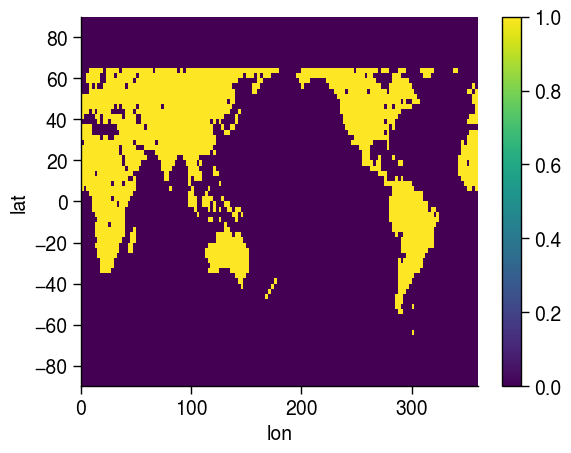

In [13]:
obs_txx_mask.plot()

wrap into dataset and write out

In [17]:
mask_ds = xr.Dataset({"txx_mask":(["lat","lon"],obs_txx_mask.values),
                      "rx1day_mask":(["lat","lon"],obs_rx1day_mask.values)},
                    coords={"lat":(["lat"],obs_txx_mask.lat.values),
                            "lon":(["lon"],obs_txx_mask.lon.values)})

mask_ds.attrs["creation_date"] = str(datetime.datetime.now())
mask_ds.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
mask_ds.attrs["created_from"] = os.getcwd()+"/Obs_Mask.ipynb"
mask_ds.attrs["dims"] = "lat x lon"

fname_out = loc_params+scen+"_obs_mmlea_parameter_masks.nc"
mask_ds.to_netcdf(fname_out,mode="w")
print(fname_out,flush=True)

/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/Fitted_Parameters/ssp585_obs_mmlea_parameter_masks.nc
